In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
vdir = 'ice' # 'ocn' or 'ice'
vnam = 'aice'#, 'photoC_diaz_zint', 'photoC_sp_zint']#,'photoC_diaz_zint','photoC_sp_zint'] # 'aice' # 'SST'
dat_clim = np.full([50, 365, 384, 320], np.nan)
#fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam[j] + '/'
fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/month_1/' + vnam + '/'

fnam = 'b.e21.BSSP370cmip6.f09_g17.LE2-1141.008.cice.h.aice.204501-205412.nc'

ncfile = xr.open_dataset(fdir + fnam)

In [6]:
# a. Select variable of interest and locate the files
vdir = 'ice' # 'ocn' or 'ice'
vnam = 'aice'
mar_aice = np.full([50, 14, 384, 320], np.nan)
sep_aice = np.full([50, 14, 384, 320], np.nan)
y1 = np.arange(1970,2011,10); y2 = np.arange(2015,2096,10)
ctr = 0; yrct = -1
for yr in np.concatenate((y1,y2), axis = 0):
    yrct = yrct + 1
    fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/month_1/' + vnam + '/'
# b. Make an array of nans to store the values from all EMs
    i = -1
    
# c. Loop through all the files in the directory, storing data in dat_clim
    for file in glob.glob(fdir + "*smbb*" + str(yr) + "01*"): #use suffix 0102 for every year but 2015 and 0101 for 2015.
        i = i + 1
        if i == 0:
            print(file)
        if yr%10 != 0:
            ctr = 60

# d. Open the netcdf and store the variable of interest as dat. Also open lon and lat.
        ncfile = xr.open_dataset(file) 
        dat = ncfile[vnam].values
        lon, lat = ncfile.TLON.values, ncfile.TLAT.values #if in 'ice', use 'TLON', in 'ocn', use 'TLONG'

# e. Interpolate lat and lon values over holes in the arrays
        ok = ~np.isnan(lon)
        xp = ok.ravel().nonzero()[0]
        fp = lon[~np.isnan(lon)]
        x  = np.isnan(lon).ravel().nonzero()[0]
        lon[np.isnan(lon)] = np.interp(x, xp, fp)

        ok = ~np.isnan(lat)
        xp = ok.ravel().nonzero()[0]
        fp = lat[~np.isnan(lat)]
        x  = np.isnan(lat).ravel().nonzero()[0]
        lat[np.isnan(lat)] = np.interp(x, xp, fp)
        
# f. Loop through the ensemble members, assigning each to its own column.
        mar_aice[i,yrct,:,:] = dat[2+ctr,:,:]
        sep_aice[i,yrct,:,:] = dat[8+ctr,:,:]


/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/month_1/aice/b.e21.BHISTsmbb.f09_g17.LE2-1151.008.cice.h.aice.197001-197912.nc
/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/month_1/aice/b.e21.BHISTsmbb.f09_g17.LE2-1251.017.cice.h.aice.198001-198912.nc
/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/month_1/aice/b.e21.BHISTsmbb.f09_g17.LE2-1251.018.cice.h.aice.199001-199912.nc
/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/month_1/aice/b.e21.BHISTsmbb.f09_g17.LE2-1301.016.cice.h.aice.200001-200912.nc
/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/month_1/aice/b.e21.BHISTsmbb.f09_g17.LE2-1231.012.cice.h.aice.201001-201412.nc
/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/month_1/aice/b.e21.BSSP370smbb.f09_g17.LE2-1251.020.cice.h.aice.201501-202412.nc
/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/month_1/aice/b.e21.BSSP370smbb.f09_g17.LE2-1231.015.cice.h.aice.202501-203412.nc
/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/month_1/aice/b.e21.BSSP370smbb.f09_

In [4]:
# b. Open up the areacello (area for ocean grid cells) file. I'll use this to calculate sea ice areal coverage
acdir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Ofx/areacello/gn/files/d20190308/areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc'
acfil = xr.open_dataset(acdir)
areacello = acfil['areacello'].values # tarea <- ocean files
areacello_ocn = np.full([384,320], np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(ncfile['aice'][5,i,j]) == False and ncfile["TLAT"][i,j] > 50:
            areacello_ocn[i,j] = areacello[i,j]


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [5]:
# Here, I classify grid cells as either being in the ice-free area (0), in the seasonal ice zone (1), or the 
# perennial ice zone (2) for each year (si_clim) and for each year and ensemble member (si_ens).
si_clim = np.full([14,384,320], np.nan); si_ens = np.full([50,14,384,320], np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(areacello_ocn[i,j]) == False:
            for yrct in np.arange(0,14):
                marice = np.mean(mar_aice[:,yrct,i,j])
                sepice = np.mean(sep_aice[:,yrct,i,j])
                si_clim[yrct,i,j] = 0
                if marice >= .15 and sepice >= .15:
                    si_clim[yrct,i,j] = 2
                elif marice >= .15:
                    si_clim[yrct,i,j] = 1
                for ens in np.arange(0,50):
                    si_ens[ens,yrct,i,j] = 0
                    if mar_aice[ens,yrct,i,j] >= .15 and sep_aice[ens,yrct,i,j] >= .15:
                        si_ens[ens,yrct,i,j] = 2
                    elif mar_aice[ens,yrct,i,j] >= .15:
                        si_ens[ens,yrct,i,j] = 1
                    

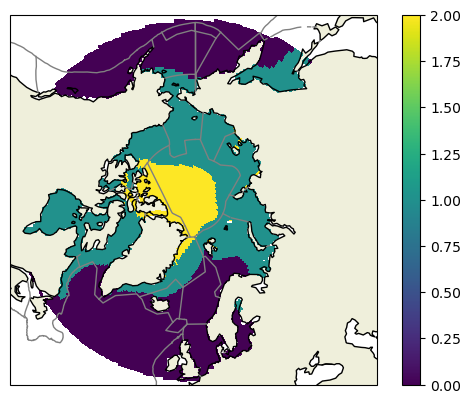

In [13]:
import shapefile as shp
sf = shp.Reader("/glade/work/kristenk/fish-offline/fish-offline/notebooks/data/LMEs66_Offshore")
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_extent([-180, 180, 49, 90], crs = ccrs.PlateCarree());
pc = ax.pcolormesh(lon, lat, si_clim2[6,:,:], transform=ccrs.PlateCarree(), vmin = 0, vmax = 2)#, cmap = 'bwr');
ax.coastlines();  ax.add_feature(cfeature.LAND); plt.colorbar(pc);

# b. Plot the lines of the LMEs.
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='grey',linewidth=1)


In [77]:
cdir = "/glade/u/home/cpayne/CESM2LE/Input/simask.nc"
ds = xr.Dataset(
    data_vars=dict(
        si_clim=(["year", "lat", "lon"], si_clim),
        si_ens=(["EM","year", "lat", "lon"], si_ens),
    ),
    coords=dict(
        TLON=(["lat", "lon"], lon),
        TLAT=(["lat", "lon"], lat),
        year=np.arange(1970,2101,10),
        EM=np.arange(0,50),
    ),
)
ds.to_netcdf(path = cdir, mode = 'w')

In [11]:
climi = xr.open_dataset("/glade/u/home/cpayne/CESM2LE/Input/simask.nc")
si_clim2 = climi["si_clim"]